In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
!pip install seaborn
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.applications import DenseNet121
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


img_size = 512   # setting our image size to a standard value 

%matplotlib inline
# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv', 'train_images', 'test_images']


# **LOADING DATA**

In [18]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [19]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


# ** EXPLORATORY DATA ANALYSIS **

From the information given the 'disagnois' column gives us a rating for each image for the severity of diabetic retinopathy on a scale of 0 to 4

0 - No DR 

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Lets establish our x and y variable for this dataset

In [20]:
x = train_df['id_code']
y = train_df['diagnosis']

To avoid any bias, we need to reset the data structure each time we run the cell above. We can do this using the shuffle object in the pandas dataframe

In [21]:
seed = 50  # defining the number of seeds in our shuffling 
x, y = shuffle(x, y, random_state=seed)

Now we need to do a count to see how many of each type of severity of diabetic retinopothy we have in our training dataset

In [22]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

It seems that the majority of the training set is made up of patients that have no DR. Overall, we can see a decrease in counts as we goes up in the the severity of DR

To better visualize this lets do a simple bar graph visualization 

Text(0, 0.5, 'Patient Count')

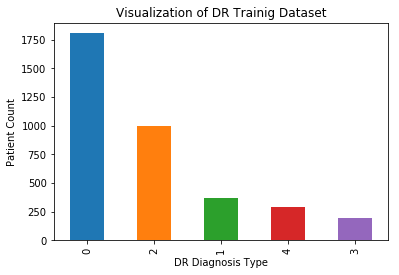

In [23]:
train_df['diagnosis'].value_counts().plot.bar()

plt.title('Visualization of DR Trainig Dataset')
plt.xlabel('DR Diagnosis Type')
plt.ylabel('Patient Count')


# **DISPLAYING SOME SAMPLE IMAGES**

The purpose of this function is to display a set of grayscale converted and cropped samples images from the given dataset 

In [24]:
def display_images(df, col=3, row=3):
    
    tol = 30  # initializing our tolerence level for cropping 

    matrix = col*row
    fig = plt.figure(figsize=(10, 10)) #definingthe size of our inline plot from matplotlib 
    
    for i in range(matrix):
        
        image_path = df.loc[i,'id_code']     # assigning the id_code of each eye image to a certain path
        image_id = df.loc[i,'diagnosis']
        
        image = cv2.imread(f'../input/train_images/{image_path}.png')
        
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting images from a RGB format to a grayscale format 
        
        mask = img>tol
        img = img[np.ix_(mask.any(1),mask.any(0))]       # converting the images into an adjusted or cropped image
        
        img = cv2.resize(img, (img_size, img_size))   # resizing our images all to a single size 
        
        
        fig.add_subplot(row, col, i+1)
        
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img,cmap='gray')
        
    plt.tight_layout()
        

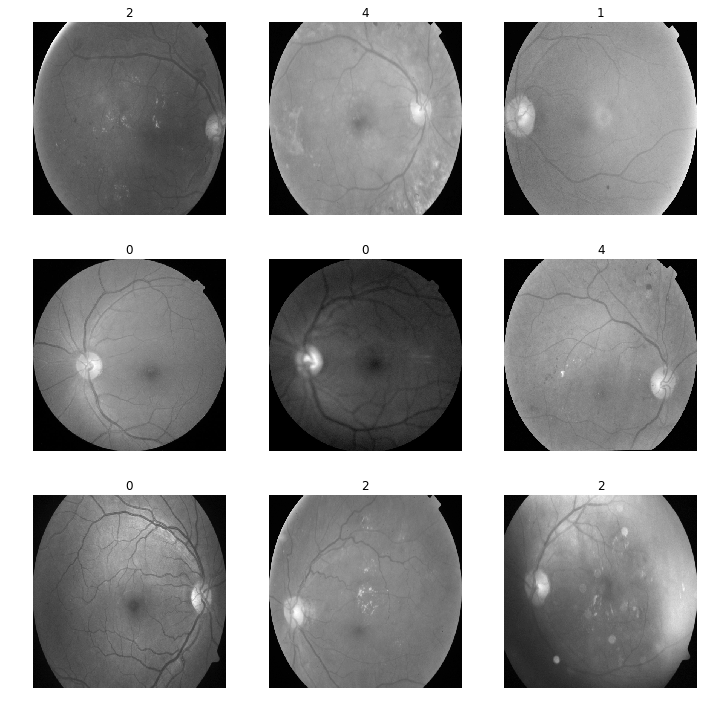

In [25]:
display_images(train_df)

# **MODEL TRAINING - DENSENET 121**

In [29]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [27]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [28]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 7,047,754
Trainable params: 6,964,106
Non-trainable params: 83,648
_________________________________________________________________
